In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.backends.backend_agg import FigureCanvas
from scipy.spatial import distance
import random
import pickle
from scipy import stats


# allow us to re-use the framework from the src directory
import sys, os
sys.path.append(os.path.abspath(os.path.join('../')))

import max_ent.examples.grid_9_by_9 as G
from max_ent.utility.support import *
from max_ent.gridworld import Directions


random.seed(123)
np.random.seed(123)

In [2]:
n_trials = 1 #

n_trajectories = 500
bootstrap = 0

threshold1 = 200 # {10, 50, 100, 200, 300} default 200
threshold2 = 0.8 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold3 = 0.9 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold4 = 200 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5
threshold5 = 0 # means default w=[1,0]
threshold7 = 0.5 # {0, 0.2, 0.4, 0.6, 0.8, 1} default 0.5


In [3]:
def compute_mean(target = None, bootstrap = 0):

    df = pd.DataFrame()

    if target: 

        for i in range(0, len(target.time_stat)):
            if i >= bootstrap:
                #print(f"Stat: {mca.trajectory_stat[i]}")
                mask_1 = np.array(target.trajectory_stat[i]) == 1
                mask_2 = np.array(target.trajectory_stat[i]) == 0

                #Creaty np array from time array
                selected = np.array(target.time_stat[i])
                #Select actions in trajectory based on which system computed them
                selected_1= selected[mask_1]
                selected_2= selected[mask_2]
                #Compute total time per solver
                time_s1 = np.sum(selected_1)
                time_s2 = np.sum(selected_2)

                #Creaty np array from trajectory array
                selected = np.array(target.trajectory_stat[i])
                #Select builder in trajectory based on which system computed them
                selected_1= selected[mask_1]
                selected_2= selected[mask_2]
                #Compute total time per solver
                usage_s1 = np.sum(selected_1)
                usage_s2 = len(target.trajectory_stat[i]) - np.sum(selected_1)

                #Creaty np array from trajectory array
                selected = np.array(target.action_reward[i])
                #Select builder in trajectory based on which system computed them
                selected_1= selected[mask_1]
                selected_2= selected[mask_2]
                #Compute total time per solver
                reward_s1 = np.sum(selected_1)
                reward_s2 = np.sum(selected_2)


                dict_mca = {}
                dict_mca['traj_n'] = i
                dict_mca['length'] = len(target.trajectory_stat[i])
                dict_mca['reward'] = np.sum(target.action_reward[i])
                dict_mca['time'] = np.sum(target.time_stat[i])

                dict_mca['time_s1'] = time_s1
                dict_mca['time_s2'] = time_s2

                dict_mca['avg_time_s1'] = time_s1 / usage_s1
                dict_mca['avg_time_s2'] = time_s2 / usage_s2

                dict_mca['reward_s1'] = reward_s1
                dict_mca['reward_s2'] = reward_s2

                dict_mca['avg_reward_s1'] = reward_s1 / usage_s1
                dict_mca['avg_reward_s2'] = reward_s2 / usage_s2

                #dict_mca['avg_time_s1'] = np.mean(selected_1)
                #dict_mca['avg_time_s2'] = np.mean(selected_2)
                dict_mca['usage_s1']= usage_s1
                dict_mca['usage_s2']= usage_s2

                temp_df = pd.DataFrame(data=dict_mca, index=[i])
                df = pd.concat([df, temp_df])
            
    else:
        dict_mca = {}
        dict_mca['traj_n'] = 0
        dict_mca['length'] = 0
        dict_mca['reward'] = 0
        dict_mca['time'] = 0

        dict_mca['time_s1'] = 0
        dict_mca['time_s2'] = 0
        
        dict_mca['avg_time_s1'] = 0
        dict_mca['avg_time_s2'] = 0
        
        dict_mca['reward_s1'] = 0
        dict_mca['reward_s2'] = 0
        
        dict_mca['avg_reward_s1'] = 0
        dict_mca['avg_reward_s2'] = 0

        #dict_mca['avg_time_s1'] = np.mean(selected_1)
        #dict_mca['avg_time_s2'] = np.mean(selected_2)
        dict_mca['usage_s1']= 0
        dict_mca['usage_s2']= 0
        temp_df = pd.DataFrame(data=dict_mca, index=[0])
        df = pd.concat([df, temp_df])

    
    #print(dict_mca)
    
    return df

In [4]:
def plot_results(df, x, y, min_label, max_label):
    fig=plt.figure(figsize=(12, 7))
    sns.set(rc={'figure.figsize':(11.7,8.27)})
    sns.set_theme(style="whitegrid")
    sns.set(font_scale=2)
    sns.color_palette("viridis", as_cmap=True)
    #g=sns.lineplot(x=x, y=y, data=df, hue="type",markers=True, dashes=False)
    g = sns.barplot(x=x, y=y, hue="type", data=df.loc[(df['type']!="const")& (df['type']!="s1") & (df['type']!="s2")], palette="autumn", ci=95);
    #g.set_xticklabels([f"({(i)/10:0.1f}, {1 - (i)/10:0.1f})" for i in range(11)])
    
    constrained_line = np.median(df.loc[(df['type']=="const")][y])
    s1_line = np.median(df.loc[(df['type']=="s1")][y])
    s2_line = np.median(df.loc[(df['type']=="s2")][y])
    
    g.axhline(constrained_line, color='r', linestyle='--', label="RL")
    g.axhline(s1_line, color='b', linestyle='--', label="S1")

    g.axhline(s2_line, color='g', linestyle='-.', label="S2")
    g.set_ylim([min_label, max_label])

    plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    plt.title(label=y+" varying "+x)
    
    plt.legend()
    plt.grid(alpha=0.3)
    #g.set_xticks(range(11)) # <--- set the ticks first

    #plt.xlabel("W(Nominal, Constraints)")
    #plt.ylabel("Avg JS dist")
    plt.show()
    #fig.savefig(os.path.join("./", f"{y}_varying_{x}.png"), bbox_inches = 'tight')
    
def build_dict(temp_matrix, type_mca, s1_usage=0,  t1=0, t2=0, t3=0, t4=0, t6=0, t7=0):
    
    temp_df = compute_mean(agent)
    temp_df['type']= type_mca
    temp_df['Length']= temp_matrix[1]
    temp_df['Reward']= temp_matrix[2]
    temp_df['Viol'] = temp_matrix[4]
    temp_df['S1_Usage'] = s1_usage
    temp_df['t1'] = t1
    temp_df['t2'] = t2
    temp_df['t3'] = t3
    temp_df['t4'] = t4
    temp_df['t6'] = t6
    temp_df['t7'] = t7
    
    return temp_df

In [5]:
## Set the grid
blue = [21,  9, 59,  1,  0, 20]
green = [42, 18, 76, 41, 23, 30]
cs = [63, 74, 13, 39, 48, 38]
ca = [Directions.DOWN_LEFT, Directions.UP_LEFT]
start =7
goal = 65

[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11aa9c0f0>}


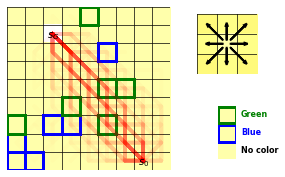

In [6]:
#blue, green, cs, ca, start, goal = generate_constraints(9)
n, n_cfg, demo_n, f1 = create_world('Nominal', blue, green, start=start, goal=goal)

[0.9625 0.0625 0.0625 0.9625 0.9625 0.0625 0.9625 0.9625]
{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11aa9c0f0>}


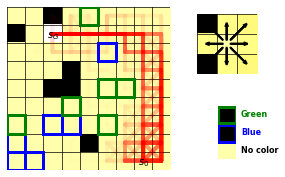

In [7]:
cc = [1, 2]
c, c_cfg, demo_c, f2 = create_world('Constrained', blue, green, cs, ca, cc, start=start, goal=goal, check=True)

In [8]:
from mc.mca import *
from max_ent.algorithms.gridworld_icrl import Demonstration

mca = MCA(n=n, c=c, demo = None, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, threshold4 = threshold4, threshold5 = 0)
demo_mca = mca.generate_trajectories(n_trajectories)

mca_01 = MCA(n=n, c=c, demo = None, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, threshold4 = threshold4, threshold5 = 1)
demo_mca_01 = mca_01.generate_trajectories(n_trajectories)

mca_02 = MCA(n=n, c=c, demo = None, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, threshold4 = threshold4, threshold5 = 2)
demo_mca_02 = mca_02.generate_trajectories(n_trajectories)


threshold1: 200


/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:155: RuntimeWarning: invalid value encountered in double_scalars
  action_thresholds[1] = current_reward / expected_avg_reward
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  action_thresholds[1] = current_reward / expected_avg_reward


threshold1: 200


/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:282: RuntimeWarning: invalid value encountered in double_scalars
  x = np.abs(current_length - expected_avg_length) / max_diff_len


threshold1: 200


In [9]:
#mca_s1 = MCA(n=n, c=c, demo=demo_c, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, only_s1=True)
#demo_mca_s1 = mca_s1.generate_trajectories(n_trajectories)


In [10]:
mca_s1_nb = MCA(n=n, c=c, demo=None, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, only_s1=True)
demo_mca_s1_nb = mca_s1_nb.generate_trajectories(n_trajectories)

threshold1: 200


In [11]:
mca_s2 = MCA(n=n, c=c, demo=None, threshold1=threshold1, threshold2=threshold2, threshold3 = threshold3, threshold5 = 1, only_s2=True)
demo_mca_s2 = mca_s2.generate_trajectories(n_trajectories)


threshold1: 200


/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:155: RuntimeWarning: invalid value encountered in double_scalars
  action_thresholds[1] = current_reward / expected_avg_reward
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:282: RuntimeWarning: invalid value encountered in double_scalars
  x = np.abs(current_length - expected_avg_length) / max_diff_len
/Users/aloreggia/Documents/GitHub/wmca/mc/mca.py:155: RuntimeWarning: divide by zero encountered in double_scalars
  action_thresholds[1] = current_reward / expected_avg_reward


{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11aa9c0f0>}


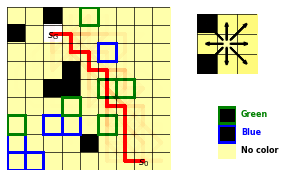

In [12]:
#print(c)
f1 = G.plot_world(f'MCA', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_mca, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11aa9c0f0>}


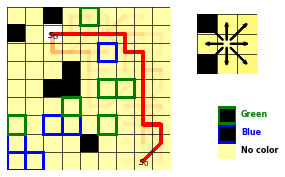

In [13]:
#print(c)
f1 = G.plot_world(f'MCA', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_mca_01, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11aa9c0f0>}


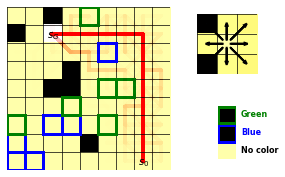

In [14]:
#print(c)
f1 = G.plot_world(f'MCA', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_mca_02, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

In [15]:
'''f1_s1 = G.plot_world(f'S1 only', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_mca_s1, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)'''

"f1_s1 = G.plot_world(f'S1 only', c, c_cfg.state_penalties, \n              c_cfg.action_penalties, c_cfg.color_penalties, \n              demo_mca_s1, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)"

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11aa9c0f0>}


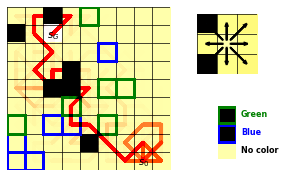

In [16]:
f1_s1 = G.plot_world(f'S1 only No RL', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_mca_s1_nb, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

{'vmin': -50, 'vmax': 10, 'cmap': <matplotlib.colors.LinearSegmentedColormap object at 0x11aa9c0f0>}


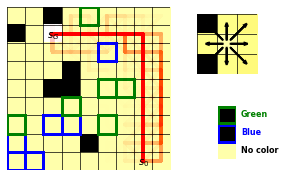

In [17]:
f1_s2 = G.plot_world(f'S2 only', c, c_cfg.state_penalties, 
              c_cfg.action_penalties, c_cfg.color_penalties, 
              demo_mca_s2, c_cfg.blue, c_cfg.green, vmin=-50, vmax=10)

In [18]:
#calcolare percentuale di utilizzo di s1 e s2 su tutte le traiettorie
#calcolare percentuale media di utilizzo di s1 e s2 in ogni traiettoria
#plottare uso di s1 e s2 in un grafo 
print("Ntraj \t cRew/avgRew \t conf \t rewS1 \t rewS2 \t costS2")
np.set_printoptions(formatter={'float': lambda x: "{:4.3f}".format(x)})
i = 2
print(mca_02.__dict__['trajectory_stat'][i])
mca_02.__dict__['thresholds_stat'][i]

Ntraj 	 cRew/avgRew 	 conf 	 rewS1 	 rewS2 	 costS2
[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1]


[array([2.000,  nan, 1.000, -88.000, -88.000, 0.119, 0.977]),
 array([1.000, 1.000, 1.000, -84.000, -84.000, 0.119, 0.883]),
 array([2.000, -inf, 1.000, -88.000, -88.000, 0.152, 0.682]),
 array([1.000, 3.000, 1.000, -84.000, -84.000, 0.179, 0.502]),
 array([2.000, 0.593, 0.506, -164.000, -164.000, 0.208, 0.276]),
 array([1.000, 5.000, 1.000, -26.000, -26.000, 0.266, 0.980]),
 array([1.000, 6.000, 1.000, -22.000, -22.000, 0.266, 0.190]),
 array([1.000, 7.000, 1.000, -18.000, -18.000, 0.312, 0.287]),
 array([1.000, 8.000, 1.000, -14.000, -14.000, 0.425, 0.525]),
 array([1.000, 9.000, 1.000, -10.000, -10.000, 0.621, 0.569]),
 array([1.000, 10.000, 1.000, -6.000, -6.000, 1.255, 0.000]),
 array([1.000, 11.000, 1.000, -2.000, -2.000, 1.255, 0.000]),
 array([1.000, 12.000, 1.000, 2.000, 2.000, 1.255, 0.000]),
 array([1.000, 13.000, 1.000, 6.000, 6.000, 1.255, 0.000])]

In [19]:
'''
avg_reward_mca = 0
for trajectory in demo_mca.trajectories:
    avg_reward_mca += mca.modelSelf.getTotalReward(trajectory)
    
print(f"{avg_reward_mca/len(demo_mca.trajectories)} su {len(demo_mca.trajectories)}")

avg_reward_c = 0
for trajectory in demo_c.trajectories:
    avg_reward_c += mca.modelSelf.getTotalReward(trajectory)
    
print(f"{avg_reward_c/len(demo_c.trajectories)} su {len(demo_c.trajectories)}")
'''


'\navg_reward_mca = 0\nfor trajectory in demo_mca.trajectories:\n    avg_reward_mca += mca.modelSelf.getTotalReward(trajectory)\n    \nprint(f"{avg_reward_mca/len(demo_mca.trajectories)} su {len(demo_mca.trajectories)}")\n\navg_reward_c = 0\nfor trajectory in demo_c.trajectories:\n    avg_reward_c += mca.modelSelf.getTotalReward(trajectory)\n    \nprint(f"{avg_reward_c/len(demo_c.trajectories)} su {len(demo_c.trajectories)}")\n'

In [20]:
from max_ent.utility.support import *

constraints = {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}

temp_matrix_c = count_states(demo_c.trajectories, c_cfg.mdp, n, constraints)

'''temp_matrix_mca = count_states(demo_mca.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
temp_matrix_mca_01 = count_states(demo_mca_01.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
temp_matrix_mca_02 = count_states(demo_mca_02.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
temp_matrix_mca_s1 = count_states(demo_mca_s1.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
temp_matrix_mca_s1_nb = count_states(demo_mca_s1_nb.trajectories, c_cfg.mdp, n, {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}, bootstrap = bootstrap)
temp_matrix_mca_s2 = count_states(demo_mca_s2.trajectories, c_cfg.mdp, n, {'blue': blue, 'green': green, 'cs':cs, 'ca':ca}, bootstrap = bootstrap)
'''
#js_divergence(temp_matrix_c,temp_matrix_mca)

temp_matrix_mca = compute_mean(mca, bootstrap = bootstrap)
temp_matrix_mca_01 = compute_mean(mca_01, bootstrap = bootstrap)
temp_matrix_mca_02 = compute_mean(mca_02, bootstrap = bootstrap)
#temp_matrix_mca_s1 = compute_mean(mca_s1, bootstrap = bootstrap)
temp_matrix_mca_s1_nb = compute_mean(mca_s1_nb, bootstrap = bootstrap)
temp_matrix_mca_s2 = compute_mean(mca_s2, bootstrap = bootstrap)



#print(mca_02.__dict__)

#print(avg_reward_n_mca)
#print(avg_reward_n_c)

#print(avg_reward_mca)
#print(avg_reward_c)

/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: RuntimeWarning: invalid value encountered in long_scalars
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:57: RuntimeWarning: invalid value encountered in double_scalars
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in long_scalars
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: invalid value encountered in double_scalars


In [21]:
#print(temp_matrix_mca_02)

def print_results(temp_matrix, type_agent):
    print(f"{type_agent}: -> Length: {np.mean(temp_matrix['length']):6.2f} ({np.mean(temp_matrix['usage_s1']):6.2f} ; {np.mean(temp_matrix['usage_s2']):6.2f}) \
 Rew: {np.mean(temp_matrix['reward']):10.4f} ({np.nanmean(temp_matrix['avg_reward_s1']):6.2f} ; {np.nanmean(temp_matrix['avg_reward_s2']):6.2f}) \
 Time: {np.mean(temp_matrix['time']):10.4f} ({np.mean(temp_matrix['avg_time_s1']):6.4f} ; {np.mean(temp_matrix['avg_time_s2']):6.4f})")

print_results(temp_matrix_mca, 'MCA_10')
print_results(temp_matrix_mca_01, 'MCA_01')
print_results(temp_matrix_mca_02, 'MCA_55')
#print_results(temp_matrix_mca_s1, 'MCA_s1')
print_results(temp_matrix_mca_s1_nb, 'MCA_nb')
print_results(temp_matrix_mca_s2, 'MCA_s2')

MCA_10: -> Length:  13.22 ( 10.67 ;   2.55)  Rew:  -118.3073 ( -9.47 ;  -3.52)  Time:    57.5100 (0.5852 ; 19.7785)
MCA_01: -> Length:  15.00 (  9.49 ;   5.51)  Rew:   -64.3210 ( -4.77 ;  -3.31)  Time:   115.7760 (0.5923 ; 20.1871)
MCA_55: -> Length:  13.77 (  8.67 ;   5.10)  Rew:   -62.6192 ( -5.05 ;  -3.56)  Time:   106.7600 (0.5446 ; 19.6395)
MCA_nb: -> Length:  48.79 ( 48.79 ;   0.00)  Rew: -2103.9914 (-42.14 ;    nan)  Time:    61.6020 (1.1482 ;    nan)
MCA_s2: -> Length:  14.82 (  0.00 ;  14.82)  Rew:   -59.6755 (   nan ;  -4.05)  Time:   304.3600 (   nan ; 20.5288)


/Users/aloreggia/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.


In [22]:
temp_matrix_mca_2 = count_states(demo_mca.trajectories, c_cfg.mdp, n, constraints, bootstrap = bootstrap)
print(f"MCA 55\t -> Length: {temp_matrix_mca_2[1]:8.4f} \t Rew: {temp_matrix_mca_2[2]:10.4f} \t Viol.: {temp_matrix_mca_2[4]} \t Counters: {temp_matrix_mca_2[5]}")

'''print(f"RL \t -> Length: {temp_matrix_c[1]:8.4f} \t Rew: {temp_matrix_c[2]:10.4f} \t Viol.: {temp_matrix_c[4]} \t Counters: {temp_matrix_c[5]}")
print(f"MCA 10\t -> Length: {temp_matrix_mca[1]:8.4f} \t Rew: {temp_matrix_mca[2]:10.4f} \t Viol.: {temp_matrix_mca[4]} \t Counters: {temp_matrix_mca[5]}")
print(f"MCA 01\t -> Length: {temp_matrix_mca_01[1]:8.4f} \t Rew: {temp_matrix_mca_01[2]:10.4f} \t Viol.: {temp_matrix_mca_01[4]} \t Counters: {temp_matrix_mca_01[5]}")
print(f"MCA 55\t -> Length: {temp_matrix_mca_02[1]:8.4f} \t Rew: {temp_matrix_mca_02[2]:10.4f} \t Viol.: {temp_matrix_mca_02[4]} \t Counters: {temp_matrix_mca_02[5]}")
print(f"Only_S1\t -> Length: {temp_matrix_mca_s1[1]:8.4f} \t Rew: {temp_matrix_mca_s1[2]:10.4f} \t Viol.: {temp_matrix_mca_s1[4]} \t Counters: {temp_matrix_mca_s1[5]}")
print(f"S1_noRL\t -> Length: {temp_matrix_mca_s1_nb[1]:8.4f} \t Rew: {temp_matrix_mca_s1_nb[2]:10.4f} \t Viol.: {temp_matrix_mca_s1_nb[4]} \t Counters: {temp_matrix_mca_s1_nb[5]}")
print(f"Only_S2\t -> Length: {temp_matrix_mca_s2[1]:8.4f} \t Rew: {temp_matrix_mca_s2[2]:10.4f} \t Viol.: {temp_matrix_mca_s2[4]} \t Counters: {temp_matrix_mca_s2[5]}")'''

MCA 55	 -> Length:  13.2200 	 Rew:  -118.3073 	 Viol.: 1.526 	 Counters: (0.062, 0.248, 0.04, 1.176)


'print(f"RL \t -> Length: {temp_matrix_c[1]:8.4f} \t Rew: {temp_matrix_c[2]:10.4f} \t Viol.: {temp_matrix_c[4]} \t Counters: {temp_matrix_c[5]}")\nprint(f"MCA 10\t -> Length: {temp_matrix_mca[1]:8.4f} \t Rew: {temp_matrix_mca[2]:10.4f} \t Viol.: {temp_matrix_mca[4]} \t Counters: {temp_matrix_mca[5]}")\nprint(f"MCA 01\t -> Length: {temp_matrix_mca_01[1]:8.4f} \t Rew: {temp_matrix_mca_01[2]:10.4f} \t Viol.: {temp_matrix_mca_01[4]} \t Counters: {temp_matrix_mca_01[5]}")\nprint(f"MCA 55\t -> Length: {temp_matrix_mca_02[1]:8.4f} \t Rew: {temp_matrix_mca_02[2]:10.4f} \t Viol.: {temp_matrix_mca_02[4]} \t Counters: {temp_matrix_mca_02[5]}")\nprint(f"Only_S1\t -> Length: {temp_matrix_mca_s1[1]:8.4f} \t Rew: {temp_matrix_mca_s1[2]:10.4f} \t Viol.: {temp_matrix_mca_s1[4]} \t Counters: {temp_matrix_mca_s1[5]}")\nprint(f"S1_noRL\t -> Length: {temp_matrix_mca_s1_nb[1]:8.4f} \t Rew: {temp_matrix_mca_s1_nb[2]:10.4f} \t Viol.: {temp_matrix_mca_s1_nb[4]} \t Counters: {temp_matrix_mca_s1_nb[5]}")\nprint(

In [23]:
mca.getStatistics(verbose=True)
mca_01.getStatistics(verbose=True)
mca_02.getStatistics(verbose=True)

n_traj = n_trajectories - bootstrap

print(np.sum(np.sum(mca.time_stat, keepdims=True)[0])/n_traj)
mca_02.__dict__['time_stat'][0]

0.8078, 0.1922
0.6291, 0.3709
0.6293, 0.3707
57.51


/Users/aloreggia/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


[0, 27, 22, 0, 25, 22, 25, 21, 27]

In [24]:

usage_s1 = []
usage_s2 = []
time_s2 = []
time_s1 = []

avg_time_s2 = []
avg_time_s1 = []

target = mca_02

for i in range(0, len(mca.time_stat)):
    #print(f"Stat: {mca.trajectory_stat[i]}")
    mask_1 = np.array(target.trajectory_stat[i]) == 1
    mask_2 = np.array(target.trajectory_stat[i]) == 0
    #print(f"Mask: {mask}")
    selected = np.array(target.time_stat[i])
    #print(f"Selected before: {selected}")
    selected_1= selected[mask_1]
    selected_2= selected[mask_2]
    #print(f"Selected after: {selected}")
    time_s1.append(np.sum(selected_1))    
    time_s2.append(np.sum(selected_2))
    avg_time_s1.append(np.mean(selected_1))    
    avg_time_s2.append(np.mean(selected_2))
    usage_s1.append(np.sum(target.trajectory_stat[i])/(len(target.trajectory_stat[i])))    
    usage_s2.append((len(target.trajectory_stat[i])-np.sum(target.trajectory_stat[i]))/(len(target.trajectory_stat[i])))
    

#print(time_s1)

/Users/aloreggia/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


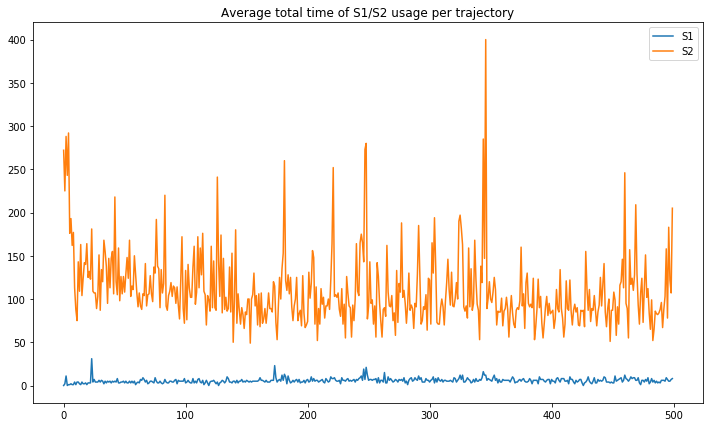

In [25]:
plt.figure(figsize=(12, 7))
plt.plot(temp_matrix_mca_01['time_s1'], label="S1")
plt.plot(temp_matrix_mca_01['time_s2'], label="S2")
plt.title("Average total time of S1/S2 usage per trajectory")

plt.legend()

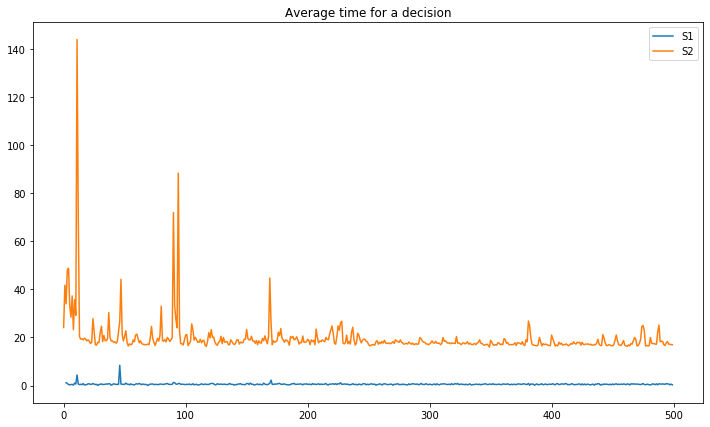

In [26]:
plt.figure(figsize=(12, 7))
plt.plot(avg_time_s1, label="S1")
plt.plot(avg_time_s2, label="S2")
plt.title("Average time for a decision")

plt.legend()


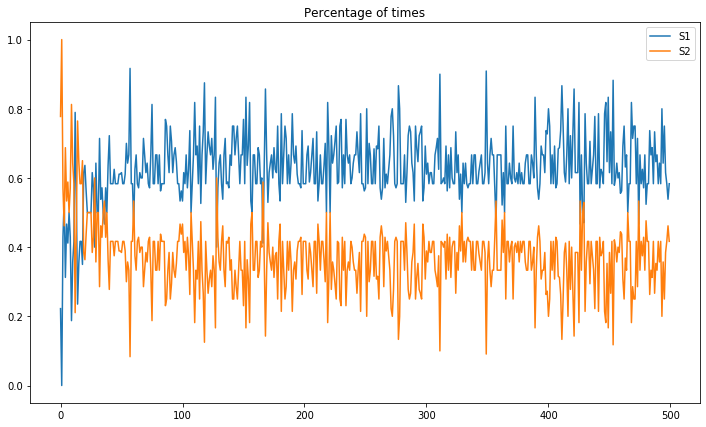

In [27]:
plt.figure(figsize=(12, 7))
plt.plot(usage_s1, label="S1")
plt.plot(usage_s2, label="S2")
plt.title("Percentage of times")
plt.legend()
plt.show()
#print(list(map(len, mca.time_stat)))

#max(list(map(len, mca.time_stat)))

In [28]:
def compute_mean(target):
    usage_s1 = []
    usage_s2 = []
    time_s2 = []
    time_s1 = []

    avg_time_s2 = []
    avg_time_s1 = []

    dict_mca = {}
    df = pd.DataFrame()
    
    for i in range(0, len(mca.time_stat)):
        #print(f"Stat: {mca.trajectory_stat[i]}")
        mask_1 = np.array(target.trajectory_stat[i]) == 1
        mask_2 = np.array(target.trajectory_stat[i]) == 0
        #print(f"Mask: {mask}")
        selected = np.array(target.time_stat[i])
        #print(f"Selected before: {selected}")
        selected_1= selected[mask_1]
        selected_2= selected[mask_2]
        #print(f"Selected after: {selected}")
        time_s1.append(np.sum(selected_1))    
        time_s2.append(np.sum(selected_2))
        avg_time_s1.append(np.mean(selected_1))    
        avg_time_s2.append(np.mean(selected_2))
        usage_s1.append(np.sum(target.trajectory_stat[i])/(len(target.trajectory_stat[i])))    
        usage_s2.append((len(target.trajectory_stat[i])-np.sum(target.trajectory_stat[i]))/(len(target.trajectory_stat[i])))
    
        dict_mca['traj_n'] = i
        dict_mca['time_s1'] = np.sum(selected_1)
        dict_mca['time_s2'] = np.sum(selected_2)
        dict_mca['avg_time_s1'] = np.mean(selected_1)
        dict_mca['avg_time_s2'] = np.mean(selected_2)
        dict_mca['usage_s1']= np.sum(target.trajectory_stat[i])/(len(target.trajectory_stat[i]))
        dict_mca['usage_s2']= (len(target.trajectory_stat[i])-np.sum(target.trajectory_stat[i]))/(len(target.trajectory_stat[i]))
        temp_df = pd.DataFrame(data=dict_mca, index=[i])
        df = pd.concat([df, temp_df])
    
    #print(dict_mca)
    
    
    return df


In [29]:
df = pd.DataFrame()

for i in range(3):
    temp_dict = compute_mean(mca_02)
    df = pd.concat([df, temp_dict])
    
df['test'] = 'andrea'
df

/Users/aloreggia/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/aloreggia/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,traj_n,time_s1,time_s2,avg_time_s1,avg_time_s2,usage_s1,usage_s2,test
0,0,0,169,0.000000,24.142857,0.222222,0.777778,andrea
1,1,0,543,NaN,41.769231,0.000000,1.000000,andrea
2,2,7,272,1.166667,34.000000,0.428571,0.571429,andrea
3,3,6,288,0.857143,48.000000,0.538462,0.461538,andrea
4,4,2,537,0.400000,48.818182,0.312500,0.687500,andrea
...,...,...,...,...,...,...,...,...
495,495,6,55,0.666667,18.333333,0.750000,0.250000,andrea
496,496,5,86,0.625000,17.200000,0.615385,0.384615,andrea
497,497,2,86,0.285714,17.200000,0.583333,0.416667,andrea
498,498,4,102,0.571429,17.000000,0.538462,0.461538,andrea


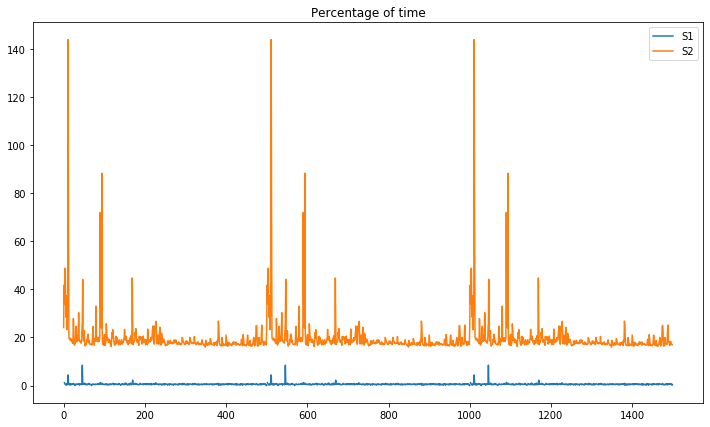

In [30]:
plt.figure(figsize=(12, 7))
plt.plot(df['avg_time_s1'].values, label="S1")
plt.plot(df['avg_time_s2'].values, label="S2")
plt.title("Percentage of time")
plt.legend()
plt.show()